In [1]:
!pip freeze > requirements.txt

# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [2]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import time

%matplotlib inline

Прочитаем исходные данные:

In [3]:
data = pd.read_csv('unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [5]:
data.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


In [6]:
num_columns = list(data.select_dtypes(include = 'number').columns)
num_columns.remove('Well')
num_columns

['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']

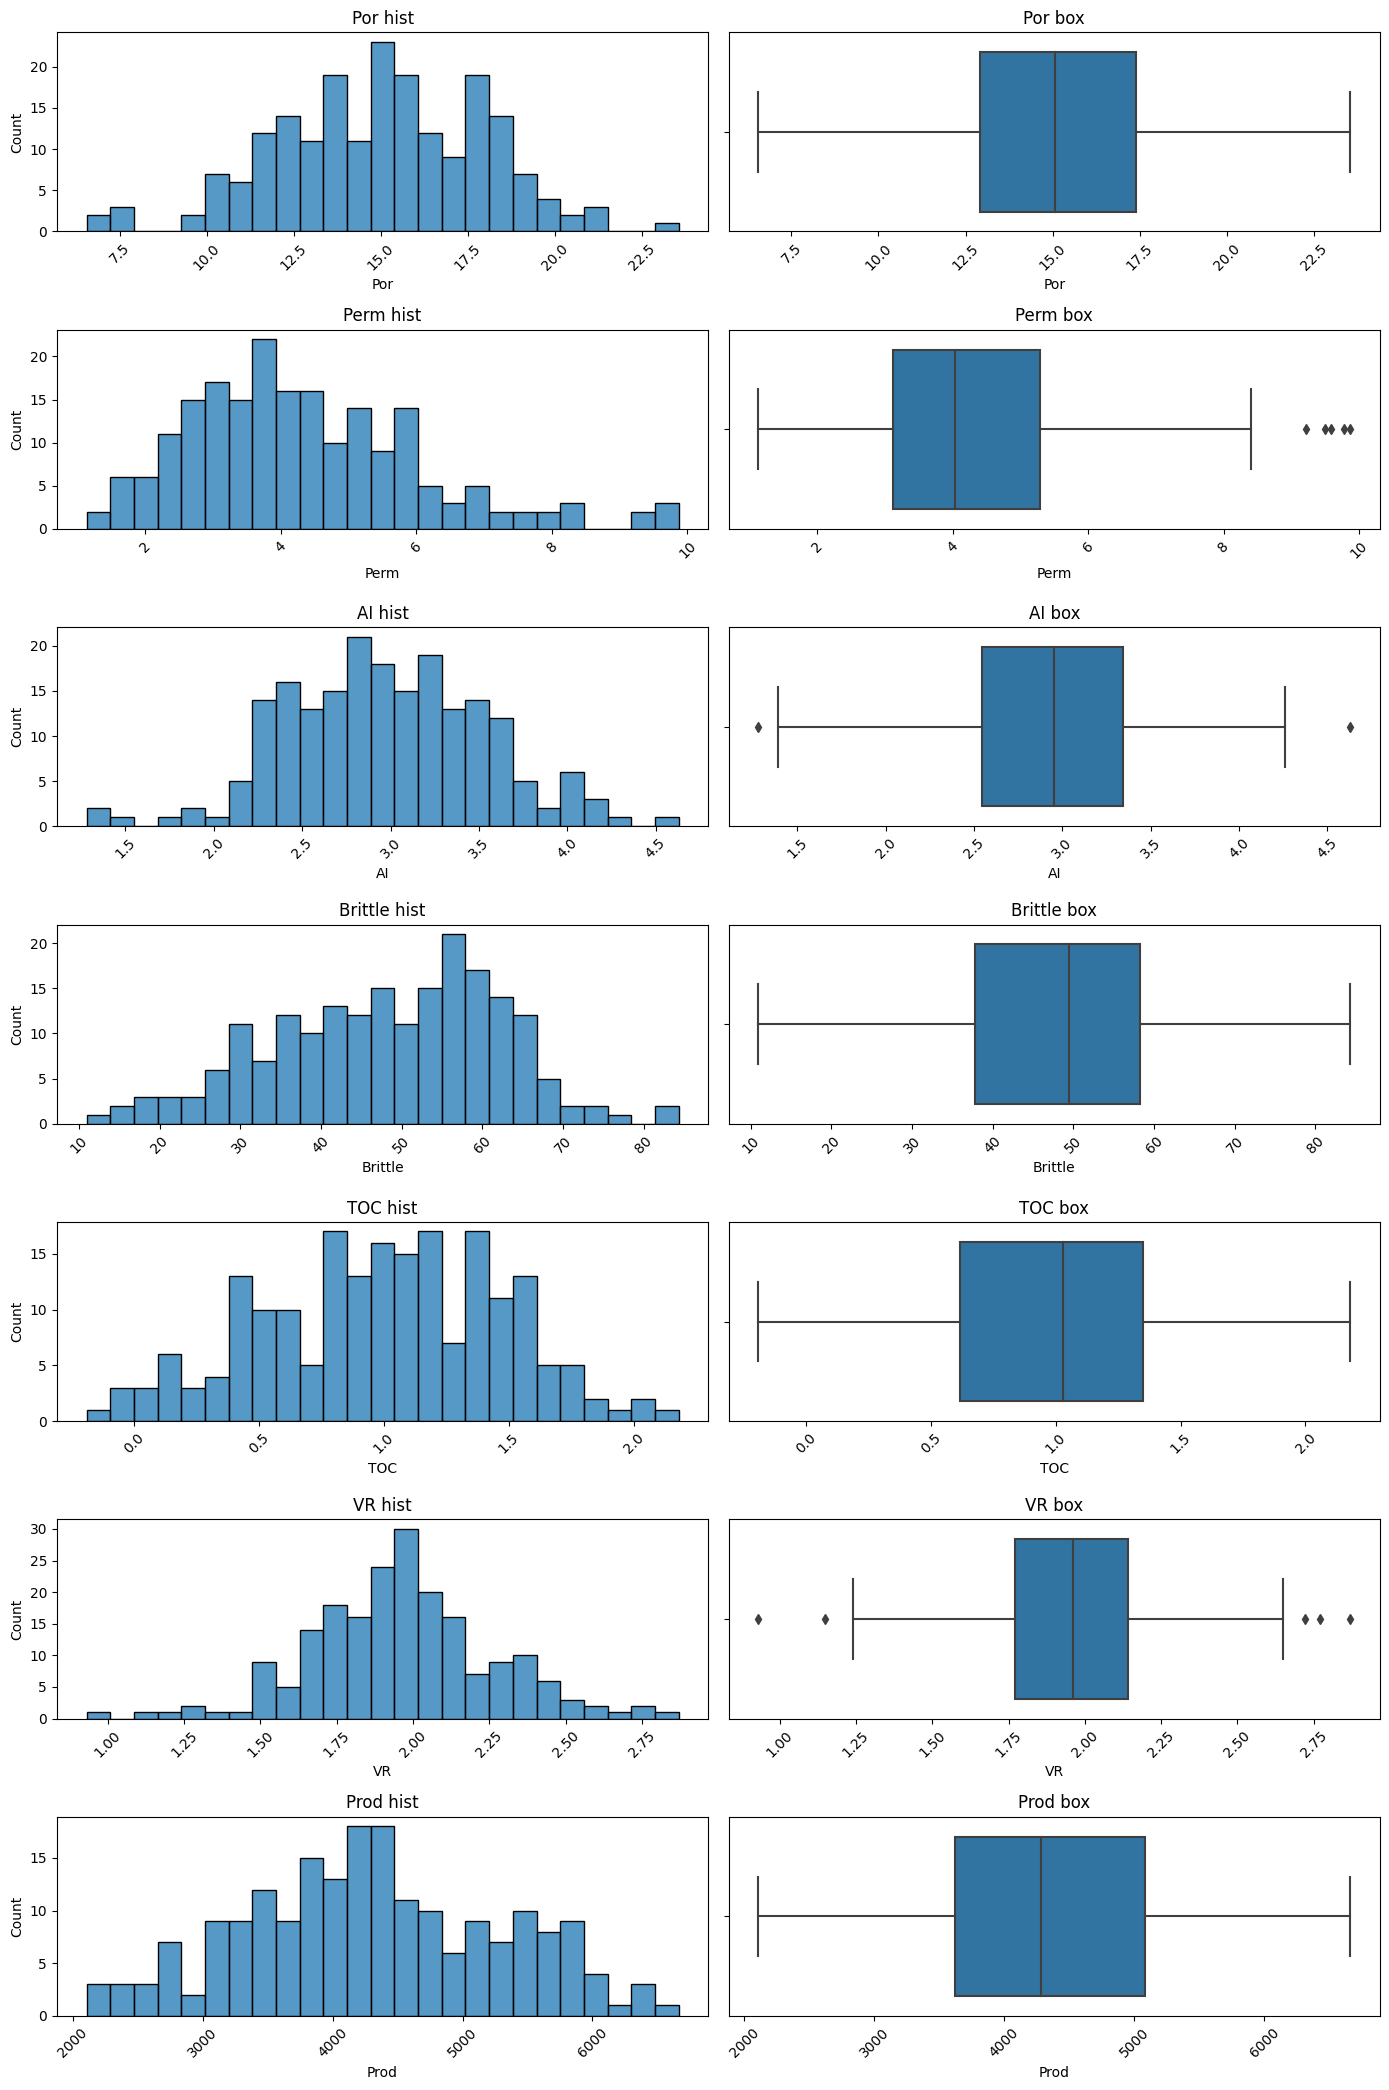

In [7]:
n = len(num_columns)
fig, axes = plt.subplots(n, 2, figsize=(14, 21))

for i, feature in enumerate(num_columns):
    histplot = sns.histplot(data=data, x=feature, bins = 25, ax=axes[i][0])
    histplot.set_title('{} hist'.format(feature))
    histplot.xaxis.set_tick_params(rotation=45)
    
    boxplot = sns.boxplot(data = data, x = feature, ax = axes[i][1])
    boxplot.set_title('{} box'.format(feature));
    boxplot.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

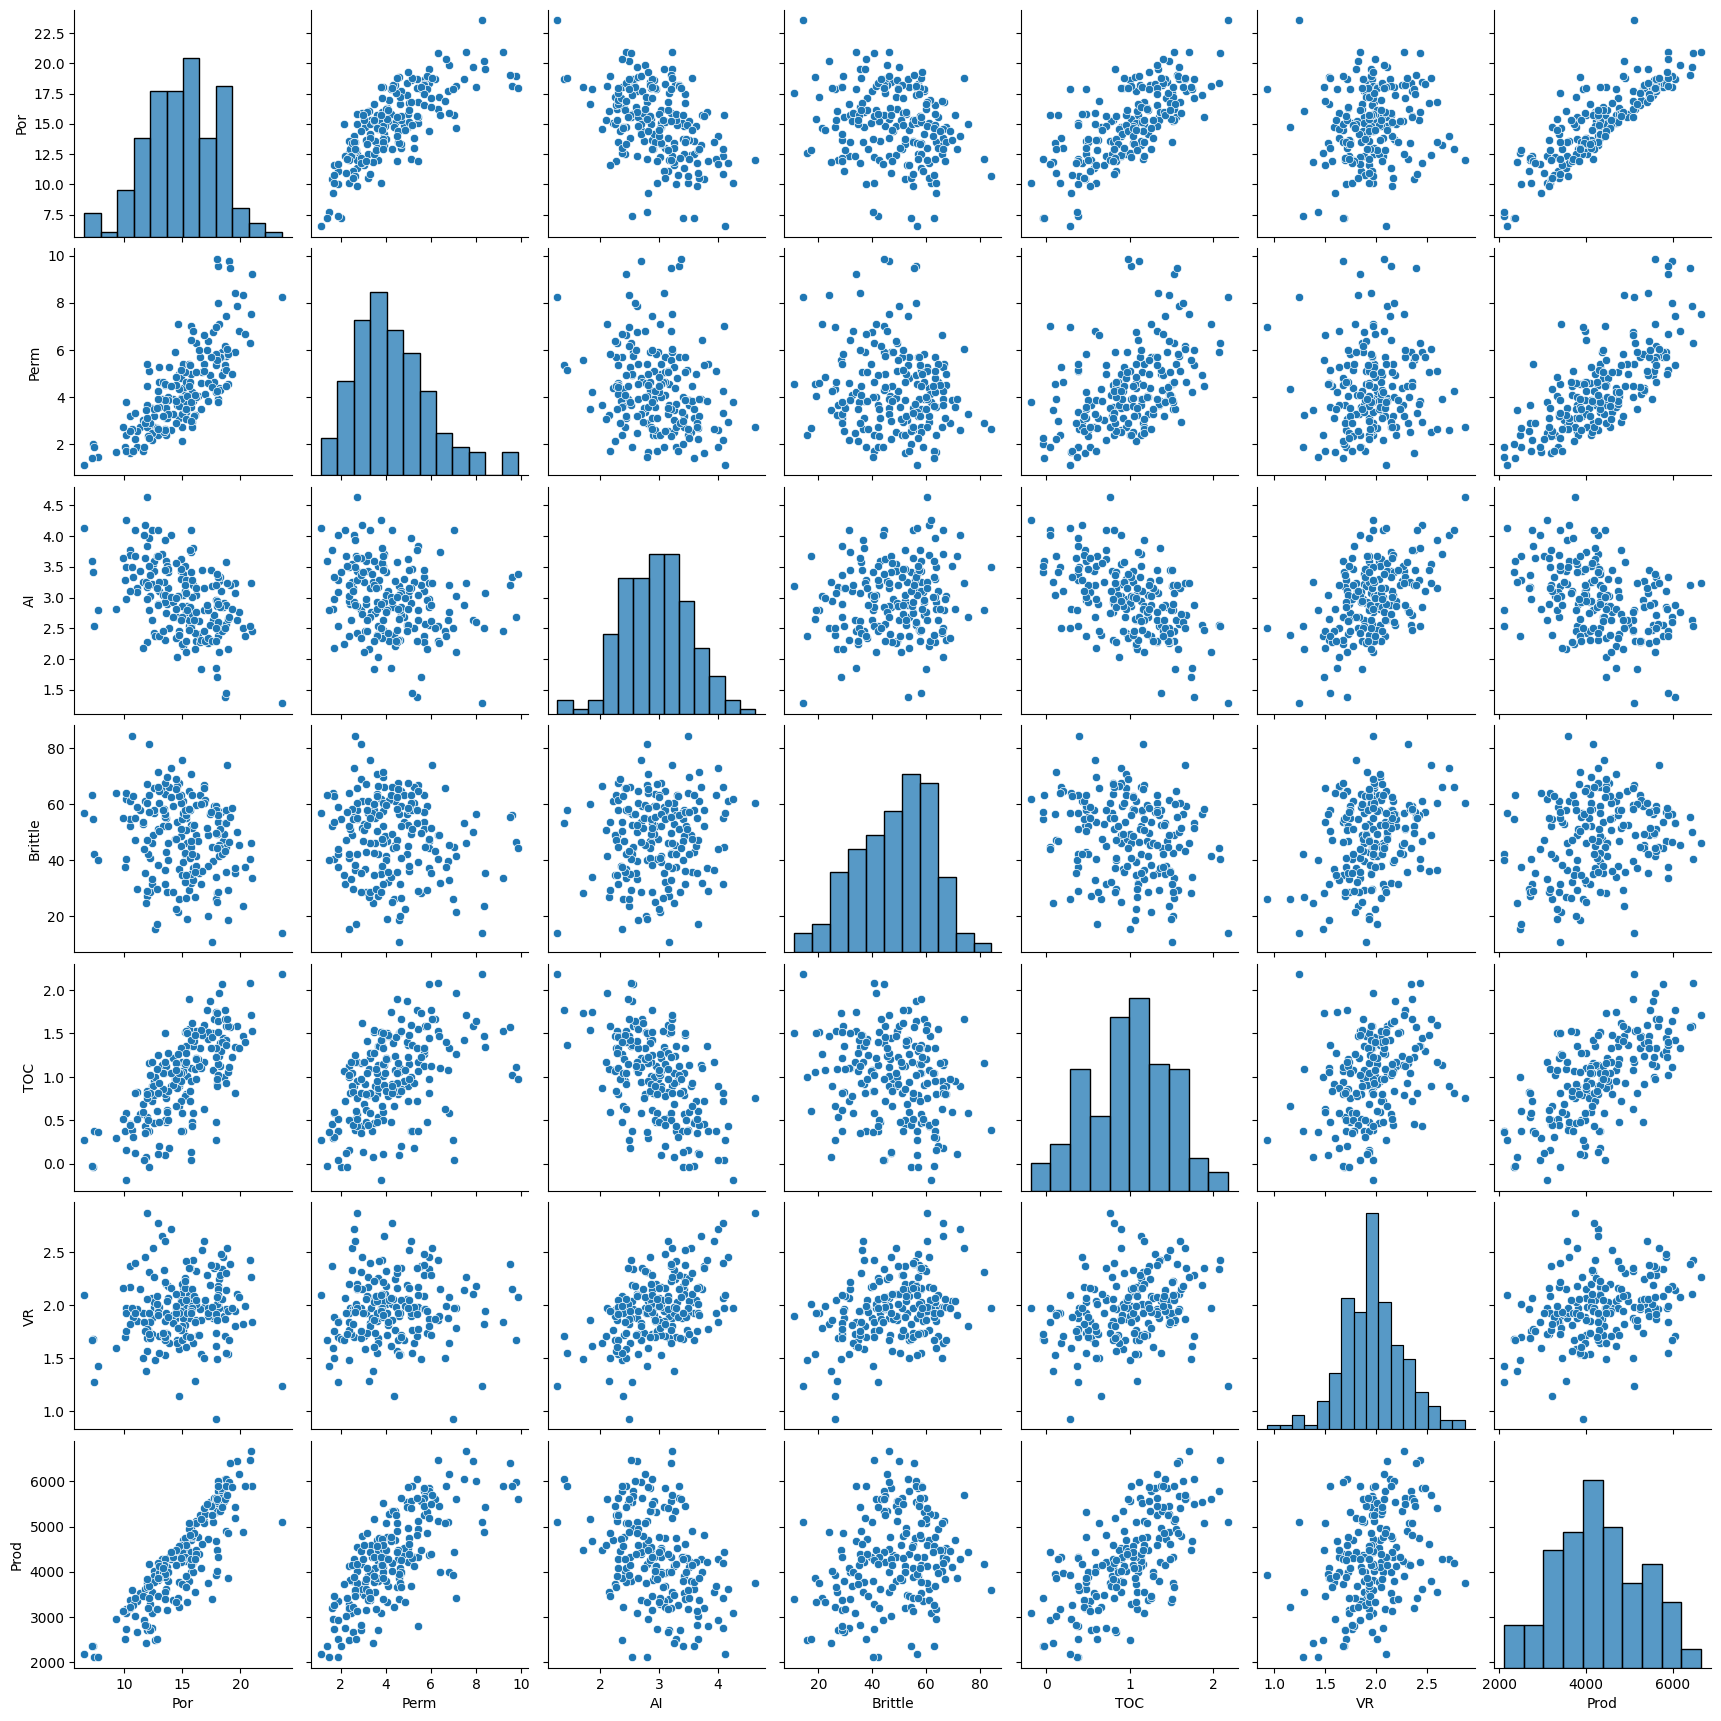

In [8]:
sns.pairplot(data[num_columns])

#### Выводы
Отметить следует три важных момента:
- признаки распределены нормально или близко к нормальному;
- выбросы практически отсутствуют;
- между некоторыми признаками имеется выраженная корреляция (Por и Perm, Por и Toc), практически линейная.   

Также приятно обнаружить данные без пропусков.   
И еще - есть сильная зависимость целевой переменной и признака Por.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [9]:
A = data.values.T

In [10]:
A_corr = np.corrcoef(A)

A_corr.shape

(8, 8)

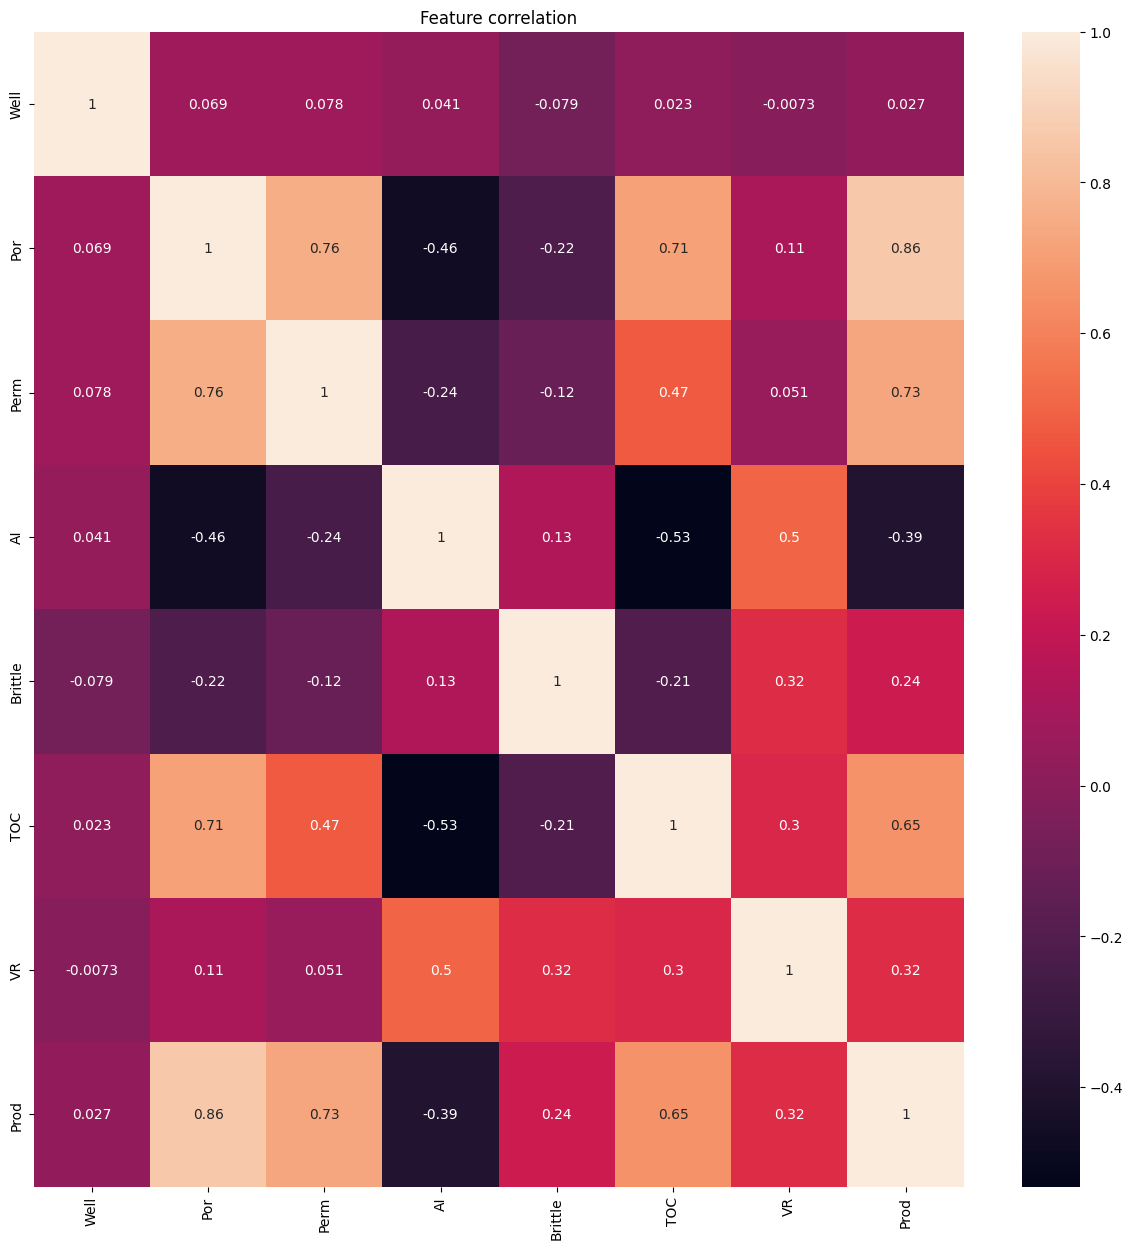

In [11]:
fig = plt.figure(figsize=(15, 15))

ax = sns.heatmap(A_corr,
                 annot = True,
                 xticklabels = data.columns,
                 yticklabels = data.columns)
ax.set_title("Feature correlation")
plt.xticks(rotation = 90)

plt.show()

Сильнее всего с целевой переменной, в порядке убывания, коррелируют Por, Perm и TOC.

In [12]:
np.linalg.matrix_rank(A_corr)

8

In [13]:
np.linalg.det(A_corr)

0.0007299388072651927

#### Выводы
Ранг матрицы корреляций равен числу ее строк (и стобцов), однако ее определитель близок в нулю.   
Таким образом, матрица хоть и не вырожденная, однако очень близка к таковой.   
   
Данные, таким образом, являются плохо обусловленными.   
   
Чистая коллинеарность в данных отсутствует, так как ранг матрицы равен числу строк и столбцов, однако из-за того, что определитель близок к нулю, можно скзаать о наличии в данных мультиколлинеарности.   

Классическая модель линейной регрессии, таким образом, не даст хорошего решения.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [14]:
X = data.drop('Prod', axis = 1).values
y = data['Prod'].values

In [15]:
w_hat = np.linalg.inv(X.T@X)@X.T@y
print(np.round(w_hat, 0))

[  -0.  185.  158. -676.   20. -273. 1125.]


#### Выводы
1. Признак Well неинформативен.
2. Данные нестандартизованы, поэтому выделить более важные по отношению к остальным признаки невозможно - они в разном масштабе.
3. Целевая переменная прямо пропорциональна признакам Por, Perm, Brittle и VR, и обратнопропорциональна признакам AI и TOC. То есть, например, если увеличить аккустический импенданс на миллион единиц (помним о шкале измерения признака), то добыча газа в сутки уменьшится на 676 млн. кубических футов. По аналогии, если увеличить проницаемость скважины на 1%, то добыча газа в сутки уведиличится на 158 млн. кубических футов.   
* на самом деле все перечисленные параметры являются наблюдаемыми либо вычисляемыми по результатам наблюдений, и влять на них мы не можем. Поэтому корректно рассуждать вот так: "если в оодной скважине параметр отличается на столько-то от того же параметра в другой скважине, то разница в добыче газа в этих скважинах в сутки пропорциональна разнице параметров с таким-то коэфициентом, и отличается на столько-то"

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [16]:
well_new = np.array([106, 15.32, 3.71, 3.29, 55.99, 1.35, 2.42]).T

In [17]:
well_pred = well_new@w_hat
print('prediction:', well_pred)

prediction: 4631.708570600802


In [18]:
print('Absolute error:', np.absolute(well_pred - 4748.315024))

Absolute error: 116.60645339919847


In [19]:
y_pred = np.zeros(y.shape[0])

In [20]:
for i in range(X.shape[0]):
    y_pred[i] = X[i]@w_hat
    
#print('MAE:', np.absolute((y - y_pred)).mean())
print('RMSE:', np.power(np.power((y - y_pred), 2).mean(), 0.5))
#print('R2:', 1 - np.sum(np.power((y - y_pred), 2)) / np.sum(np.power((y - y.mean()), 2)))
sMAPE_1 = (np.absolute(y - y_pred) / y).mean() * 100
print('MAPE, %:', sMAPE_1)

RMSE: 220.61688865395678
MAPE, %: 3.9828105603293222


#### Выводы
В качестве первой метрики используется квадратный корень среднеквадратичной погрешности.   
Выбор обусловлен отсутствием существенных выбросов в исходных данных, которые могли бы отрицательно повлиять на метрику.   
Значение квадратного корня среднеквадратичной погрешности лежит в разумных пределах относительно целевой переменной.   
Для интерпретации данной метрики вычислена дополнительная метрика - средний процент абсолютной ошибки. Ее значение говорит о некотором переобучении модели, так как парметр близок к 0.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [21]:
np.round(A_corr[-1], 2)

array([ 0.03,  0.86,  0.73, -0.39,  0.24,  0.65,  0.32,  1.  ])

In [22]:
np.round(w_hat, 0)

array([  -0.,  185.,  158., -676.,   20., -273., 1125.])

#### Выводы
Признак TOC ведет себя нелогично - коэффициент в модели линейной регрессии отрицательный, тогда как соответствующий коэффициент корреляции положительный.   
Полагаю, данный эффект напрямую связан с мультиколлинеарностью.   
   
Также слежует отметить аналогичную разницу в знаках коэффициентов для признака Well, но его не следует принимать во мнимание - влияние его на целевой показатель околонулевое.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [23]:
exclude_columns = ['Well', 'Perm', 'TOC']

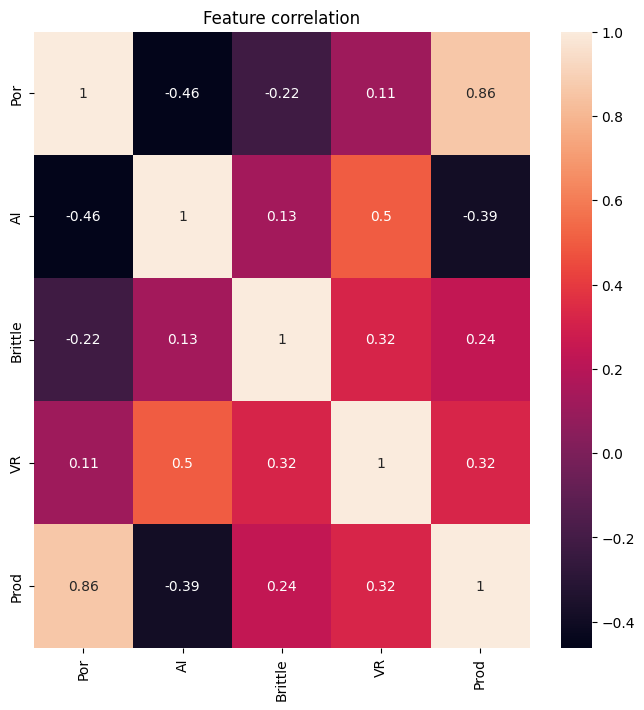

In [24]:
fig = plt.figure(figsize=(8, 8))

ax = sns.heatmap(data.drop(exclude_columns, axis = 1).corr(),
                 annot = True)
ax.set_title("Feature correlation")
plt.xticks(rotation = 90)

plt.show()

In [25]:
data.drop(exclude_columns, axis = 1).corr().values[-1]

array([ 0.86190954, -0.39083477,  0.23715533,  0.32318155,  1.        ])

In [26]:
exclude_columns.append('Prod')

In [27]:
X_clean = data.drop(exclude_columns, axis = 1).values

In [28]:
w_hat_clean = np.linalg.inv(X_clean.T@X_clean)@X_clean.T@y
print(np.round(w_hat_clean, 0))

[ 235. -486.   22.  598.]


In [29]:
y_pred_clean = np.zeros(y.shape[0])

In [30]:
for i in range(X_clean.shape[0]):
    y_pred_clean[i] = X_clean[i]@w_hat_clean
    
#print('MAE:', np.absolute((y - y_pred)).mean())
print('RMSE:', np.power(np.power((y - y_pred_clean), 2).mean(), 0.5))
#print('R2:', 1 - np.sum(np.power((y - y_pred_clean), 2)) / np.sum(np.power((y - y.mean()), 2)))
sMAPE_2 = (np.absolute(y - y_pred_clean) / y).mean() * 100
print('MAPE, %:', sMAPE_2)

RMSE: 285.8738628869156
MAPE, %: 5.025350683881418


#### Выводы
1. Знаки коэффициентов для оставленных парметров не изменились, а значит, не изменилась и их интерпретация. Можно, однако, отметить, что разброс коэффициентов стал почти вдвое меньше. В частности, для параметра VR двукратное уменьшение коэффициента означает снижение в два раза влияния на целевой показатель по сравнению с предыдущей моделью.
2. Значения выбранных метрик изменились. Корень среднеквадратичной погрешности несколько увеличился, но остался в разумных пределах относительно значений целевого параметра. MAPE увиеличился примерно на 2 процента, что говорит о снижении переобучения относительно первой модели.
3. Противоречия в коэффициентах модели и корреляции устранены.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [31]:
model = LinearRegression(fit_intercept=False)

model.fit(X_clean, y)

print('w_hat_model:', np.round(model.coef_,0))

w_hat_model: [ 235. -486.   22.  598.]


In [32]:
y_pred_model = model.predict(X_clean)

print('RMSE:', np.power(mean_squared_error(y, y_pred_model), 0.5))
sMAPE_3 = mean_absolute_percentage_error(y, y_pred_model) * 100
print('MAPE, %:', sMAPE_3)

RMSE: 285.8738628869156
MAPE, %: 5.025350683881527


#### Выводы
Результат применения библиотечных функций полностью идентичен результату, полученному вручную.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [33]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

poly = PolynomialFeatures(degree = 3, include_bias = False)
X_poly = poly.fit_transform(X_scaled)

X_poly.shape[1]

34

In [35]:
model_poly = LinearRegression()

In [36]:
cv_results = cross_validate(model_poly, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

tMAPE_4 = -cv_results['train_score'].mean() * 100
print('MAPE на тренировочных фолдах:', tMAPE_4)
vMAPE_4 = -cv_results['test_score'].mean() * 100
print('MAPE на валидационных фолдах:', vMAPE_4)

MAPE на тренировочных фолдах: 1.7732404749972877
MAPE на валидационных фолдах: 2.6808754502486587


#### Выводы
Полиномиальная регрессия позволила существенно снизить MAPE относительно линейной регрессии на очищеном датасете. Небольшая разница между тренировочными и валидационной выборками говорит о хорошем качестве модели, а использование кросс-валидации снижает переобучение.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [37]:
param_grid = [{'alpha': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20]}]

grid_search_lasso = GridSearchCV(
    estimator = Lasso(),
    param_grid = param_grid,
    cv = 5,
    scoring = 'neg_mean_absolute_percentage_error',
    n_jobs = -1
    )

start = time.time()
  
grid_search_lasso.fit(X_poly, y)

print('Optimisation time: {}'.format(time.time() - start))
print("Best parameters:\n{}".format(grid_search_lasso.best_params_))

Optimisation time: 4.433167219161987
Best parameters:
{'alpha': 5}


In [38]:
lasso_opt = Lasso(**grid_search_lasso.best_params_)

In [39]:
cv_lasso = cross_validate(lasso_opt, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

tMAPE_5 = -cv_lasso['train_score'].mean() * 100
print('MAPE на тренировочных фолдах:', tMAPE_5)
vMAPE_5 = -cv_lasso['test_score'].mean() * 100
print('MAPE на валидационных фолдах:', vMAPE_5)


MAPE на тренировочных фолдах: 1.8279305719510128
MAPE на валидационных фолдах: 2.276158066543644


#### Выводы
По сравнению с регрессей без регуляризации метод Lasso дал лучший результат - разница между метриками на тренировочных и валидационной выборках сократилась, при этом метрика на тренировочных выборках следка увеличилась, а метрика на валидационной выборке довольно значительно уменьшилась.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [40]:
param_grid = [{'alpha': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20]}]

grid_search_ridge = GridSearchCV(
    estimator = Ridge(),
    param_grid = param_grid,
    cv = 5,
    scoring = 'neg_mean_absolute_percentage_error',
    n_jobs = -1
    )

start = time.time()
  
grid_search_ridge.fit(X_poly, y)

print('Optimisation time: {}'.format(time.time() - start))
print("Best parameters:\n{}".format(grid_search_ridge.best_params_))

Optimisation time: 0.1000208854675293
Best parameters:
{'alpha': 0.2}


In [41]:
ridge_opt = Ridge(**grid_search_ridge.best_params_)

In [42]:
cv_ridge = cross_validate(ridge_opt, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

tMAPE_6 = -cv_ridge['train_score'].mean() * 100
print('MAPE на тренировочных фолдах:', tMAPE_6)
vMAPE_6 = -cv_ridge['test_score'].mean() * 100
print('MAPE на валидационных фолдах:', vMAPE_6)


MAPE на тренировочных фолдах: 1.7739393193863011
MAPE на валидационных фолдах: 2.672457369619574


#### Выводы
Результаты регуляризации по Тихонову практически не отличаются от обычной полиномиальной регрессии, и несколько уступают Lasso.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [43]:
param_grid = [{'alpha': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20],
               'l1_ratio': [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]}]

grid_search_elastic = GridSearchCV(
    estimator = ElasticNet(),
    param_grid = param_grid,
    cv = 5,
    scoring = 'neg_mean_absolute_percentage_error',
    n_jobs = -1
    )

start = time.time()
  
grid_search_elastic.fit(X_poly, y)

print('Optimisation time: {}'.format(time.time() - start))
print("Best parameters:\n{}".format(grid_search_elastic.best_params_))

Optimisation time: 0.4320969581604004
Best parameters:
{'alpha': 5, 'l1_ratio': 1}


In [44]:
elastic_opt = ElasticNet(**grid_search_elastic.best_params_)

In [45]:
cv_elastic = cross_validate(elastic_opt, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

tMAPE_7 = -cv_elastic['train_score'].mean() * 100
print('MAPE на тренировочных фолдах:', tMAPE_7)
vMAPE_7 = -cv_elastic['test_score'].mean() * 100
print('MAPE на валидационных фолдах:', vMAPE_7)


MAPE на тренировочных фолдах: 1.8279305719510128
MAPE на валидационных фолдах: 2.276158066543644


#### Выводы
Вполне логичным образом метод эластичной сетки сошелся к методу Lasso, так как данный метод показал самые высокие результаты по метрикам для множества парметров, которые мы рассматривали.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [46]:
result_df = pd.DataFrame({
    'Model_Name': ['By hand - All Data', 'By hand - Clean Data', 'ML Simple - Clean Data', 'ML CV Simple - Clean Data',
                   'ML CV Lasso - Clean Data', 'ML CV Ridge - Clean Data', 'ML CV ElasticNet - Clean Data'],
    'Hyperparameters': [np.nan, np.nan, np.nan, np.nan, grid_search_lasso.best_params_.values(), grid_search_ridge.best_params_.values(), grid_search_elastic.best_params_.values()],
    'Polynomial': [False, False, False, True, True, True, True],
    'Metric on training folds': [sMAPE_1, sMAPE_2, sMAPE_3, tMAPE_4, tMAPE_5, tMAPE_6, tMAPE_7],
    'Metric on validation folds': [np.nan, np.nan, np.nan, vMAPE_4, vMAPE_5, vMAPE_6, vMAPE_7]
    },
                         index = [1, 2, 3, 4, 5, 6, 7])

In [47]:
result_df

,Model_Name,Hyperparameters,Polynomial,Metric on training folds,Metric on validation folds
1,By hand - All Data,NaN,False,3.982811,NaN
2,By hand - Clean Data,NaN,False,5.025351,NaN
3,ML Simple - Clean Data,NaN,False,5.025351,NaN
4,ML CV Simple - Clean Data,NaN,True,1.773240,2.680875
5,ML CV Lasso - Clean Data,(5),True,1.827931,2.276158
6,ML CV Ridge - Clean Data,(0.2),True,1.773939,2.672457
7,ML CV ElasticNet - Clean Data,"(5, 1)",True,1.827931,2.276158


#### Выводы
1. С точки зрения значения метрики на валидационной выборке лучше всего показывают себя модели Lasso и ElasticNet. При этом несложно заметить, что более сложная ElasticNet из-за значений гиперпараметров сводится к Lasso, что подтвержается равенством метрик.
2. Наименьшая разница в значениях метрики на тренировочных и валидационном фолдах достигается, опять же, для метода Lasso, что говорит о низком переобучении для конкретного датасета.

Здесь нужен комментарий - если верно, чтот данные по скважинам взяты из реального источника в пределах одного меторождения, сравнительно маленький процент ошибки вполне логичен. Естественные природные процессы хорошо детерминированы, и, зная некоторые параметры, их можно предсказывать очень надежно. Недаром почти все распределения параметров выглядели как нормальные или близкие к ним на графиках, равно как и распределение целевого признака. Поэтому тут стоит говорить не о переобучении, а о хорошей изученности данных и их полноте относительно поставленной задачи, интерпретируя средние значения метрики по методам моделирования.